In [14]:
from scipy import stats
import numpy as np
import pandas as pd

from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML,display

from ast import literal_eval as make_tuple

from os import listdir
from os.path import isfile, join, splitext, basename
import csv
import itertools

%matplotlib inline

In [15]:
def csv_length(data):
    length = 0
    with open(data, 'r') as f:
        reader = csv.reader(f)
        length = len(next(reader))
    return length

In [16]:
data_path = './data/deviation'
data_list = [join(data_path, f) for f in listdir(data_path) if isfile(join(data_path, f))] 
num_list = [csv_length(data) for data in data_list]

In [17]:
def ingest(data, nums):
    tmp = pd.read_csv(data, names = [i for i in range(nums)])
    tmp_sers = [tmp[i].dropna() for i in range(nums)]
    
    tmp_chkpoints = [ser[:ser[ser.str.contains('Score')].index[0]] for ser in tmp_sers]
    tmp_datas = [ser[ser[ser.str.contains('Score')].index[0]+1:] for ser in tmp_sers]
    return tmp_chkpoints, tmp_datas

def make_arrays(sers):
    ret = [ser.apply(lambda x: np.array(make_tuple(x))) for ser in sers]
    return ret

def refine(sers):
    ret = [ser[(ser.apply(lambda x: x[2]) >= 0) & (ser.apply(lambda x: x[2]) <= 600)].reset_index(drop=True) for ser in sers]
    return ret

def find_distance(chkpoint, data):
    cur_chkpoint_idx = 0
    prv_chkpoint = data[0]
    cur_chkpoint = chkpoint[0]
    
    ser_list = []
    
    for point in data:
        if point[2] > cur_chkpoint[2]:
            cur_chkpoint_idx += 1
            if cur_chkpoint_idx > (len(chkpoint) - 1):
                break
            prv_chkpoint = chkpoint[cur_chkpoint_idx-1]
            cur_chkpoint = chkpoint[cur_chkpoint_idx]
#             print('current point=%s, current prev=%s, current=%s' % (point, prv_chkpoint, cur_chkpoint))
        d = norm(np.cross(cur_chkpoint - prv_chkpoint, prv_chkpoint - point)) / norm(cur_chkpoint - prv_chkpoint)
        ser_list.append(d)
        
    return pd.Series(ser_list)

In [18]:
def make_result(data, nums):
    chkpoints, datas = ingest(data, nums)
    chkpoints, datas = make_arrays(chkpoints), make_arrays(datas)
    chkpoints, datas = refine(chkpoints), refine(datas)
    result = [find_distance(chkpoints[i], datas[i]) for i in range(nums)]
    
    return result

In [19]:
res_dict = {splitext(basename(data))[0]: make_result(data, nums) for data, nums in zip(data_list, num_list)}

In [20]:
res_dict_std = {key: [np.std(item) for item in value] for key, value in res_dict.items()}

In [21]:
res_dict_std_t1 = {key: value for key, value in res_dict_std.items() if '_t1' in key}
res_dict_std_com = {key: value for key, value in res_dict_std.items() if '_com' in key}

In [22]:
res_dict_t1 = {key: value for key, value in res_dict.items() if '_t1' in key}
res_dict_com = {key: value for key, value in res_dict.items() if '_com' in key}

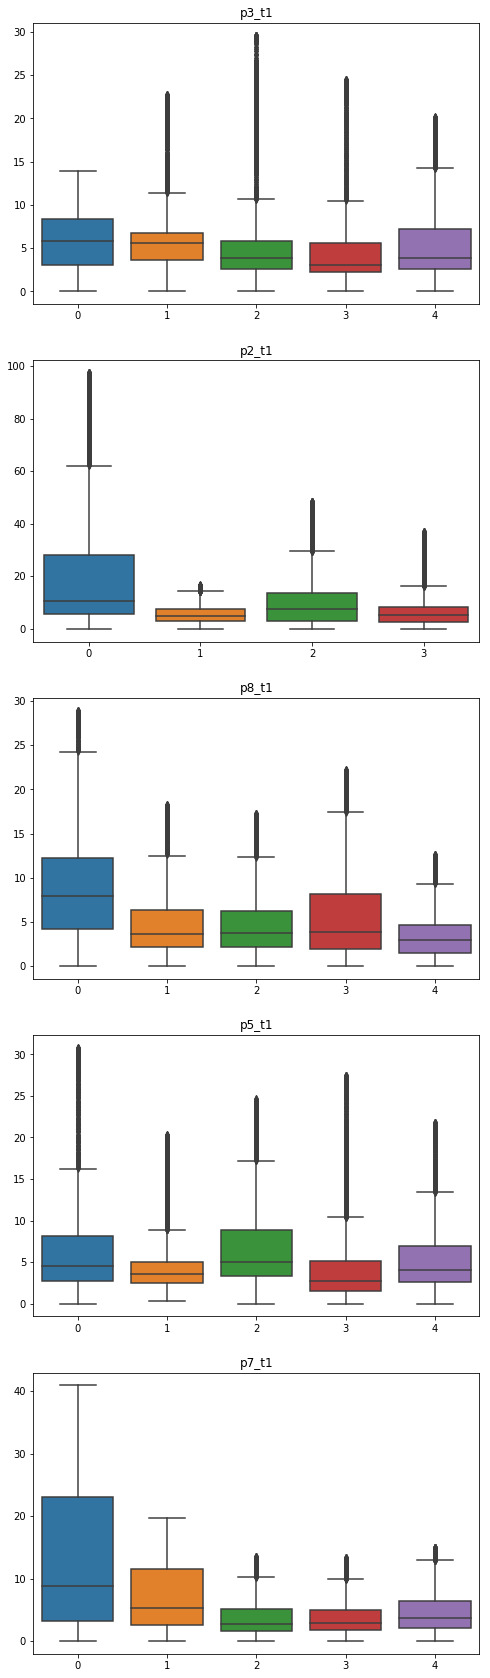

In [23]:
f, axes = plt.subplots(len(res_dict_t1), 1, figsize=(8, 30))
for key, ax in zip(res_dict_t1, axes):
    data = [np.array(ser.values) for ser in res_dict_t1[key]]
    sns.boxplot(data=data, ax=ax)
    ax.set_title(key)

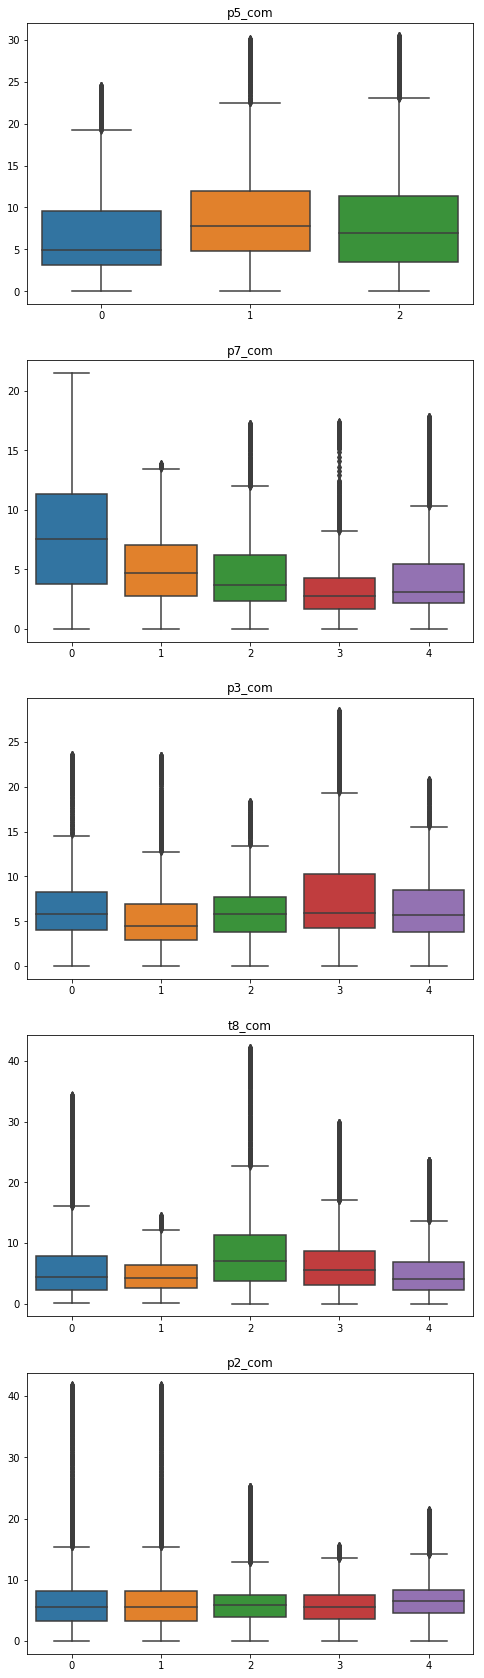

In [24]:
f, axes = plt.subplots(len(res_dict_t1), 1, figsize=(8, 30))
for key, ax in zip(res_dict_com, axes):
    data = [np.array(ser.values) for ser in res_dict_com[key]]
    sns.boxplot(data=data, ax=ax)
    ax.set_title(key)

In [25]:
res_mean_list_t1 = []
res_mean_list_com = []
for t1, com in zip(res_dict_t1, res_dict_com):
    res_mean_list_t1 += [np.mean(ser.values) for ser in res_dict_t1[t1]]
    res_mean_list_com += [np.mean(ser.values) for ser in res_dict_com[com]]

(3, 10)

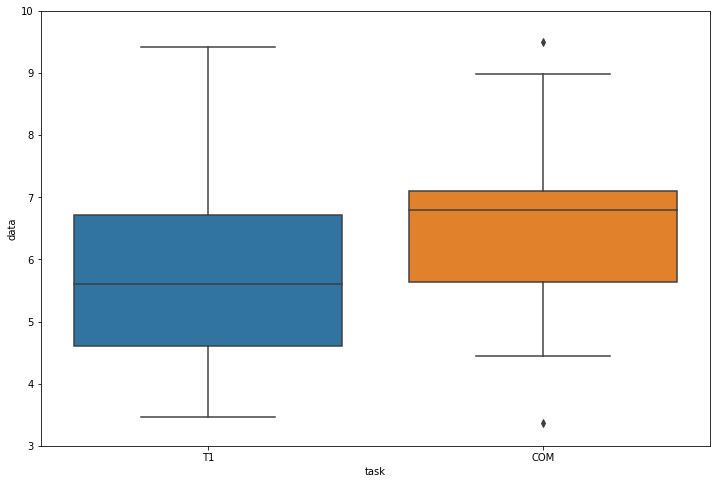

In [26]:
plt.subplots(figsize=(12,8))
whole_list = {'data' : res_mean_list_t1 + res_mean_list_com, 'task': ['T1' for item in res_mean_list_t1] + ['COM' for item in res_mean_list_com]}
data = pd.DataFrame(whole_list)
sns.boxplot(x='task', y='data', data=data)
plt.ylim((3, 10))

In [27]:
print('----T-Test over Mean Values----')
print('[Mean] T1: %.3f / COM: %.3f' % (np.mean(data[data['task'] == 'T1']['data'].values), np.mean(data[data['task'] == 'COM']['data'].values)))
print('[Std] T1: %.3f / COM: %.3f' % (np.std(data[data['task'] == 'T1']['data'].values), np.std(data[data['task'] == 'COM']['data'].values)))
ttestResult = stats.ttest_ind(data[data['task'] == 'T1']['data'].values, data[data['task'] == 'COM']['data'].values, equal_var=False)
print('[T-Test] T: %.3f / p: %.3f' % ttestResult)

----T-Test over Mean Values----
[Mean] T1: 6.576 / COM: 6.566
[Std] T1: 3.584 / COM: 1.518
[T-Test] T: 0.013 / p: 0.990


(2, 10)

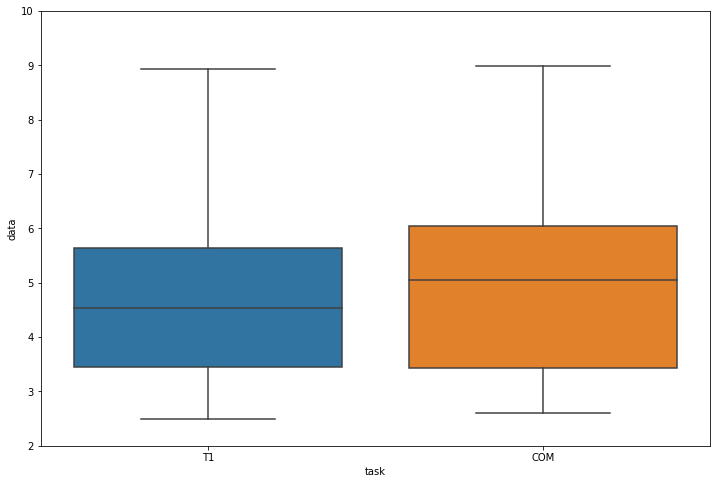

In [28]:
res_std_list_t1 = []
res_std_list_com = []
for t1, com in zip(res_dict_t1, res_dict_com):
    res_std_list_t1 += [np.std(ser.values) for ser in res_dict_t1[t1]]
    res_std_list_com += [np.std(ser.values) for ser in res_dict_com[com]]
    
plt.subplots(figsize=(12,8))
whole_list = {'data' : res_std_list_t1 + res_std_list_com, 'task': ['T1' for item in res_std_list_t1] + ['COM' for item in res_std_list_com]}
data = pd.DataFrame(whole_list)
sns.boxplot(x='task', y='data', data=data)
plt.ylim((2, 10))

In [29]:
print('----T-Test over Std Values----')
print('[Mean] T1: %.3f / COM: %.3f' % (np.mean(data[data['task'] == 'T1']['data'].values), np.mean(data[data['task'] == 'COM']['data'].values)))
print('[Std] T1: %.3f / COM: %.3f' % (np.std(data[data['task'] == 'T1']['data'].values), np.std(data[data['task'] == 'COM']['data'].values)))
ttestResult = stats.ttest_ind(data[data['task'] == 'T1']['data'].values, data[data['task'] == 'COM']['data'].values, equal_var=False)
print('[T-Test] T: %.3f / p: %.3f' % ttestResult)

----T-Test over Std Values----
[Mean] T1: 5.499 / COM: 4.900
[Std] T1: 3.909 / COM: 1.629
[T-Test] T: 0.676 / p: 0.504


In [30]:
res_list_t1 = []
res_list_com = []
for t1, com in zip(res_dict_t1, res_dict_com):
    res_list_t1 += [ser.values for ser in res_dict_t1[t1]]
    res_list_com += [ser.values for ser in res_dict_com[com]]
res_list_t1 = np.concatenate(res_list_t1).ravel()
res_list_com = np.concatenate(res_list_com).ravel()

(-1, 20)

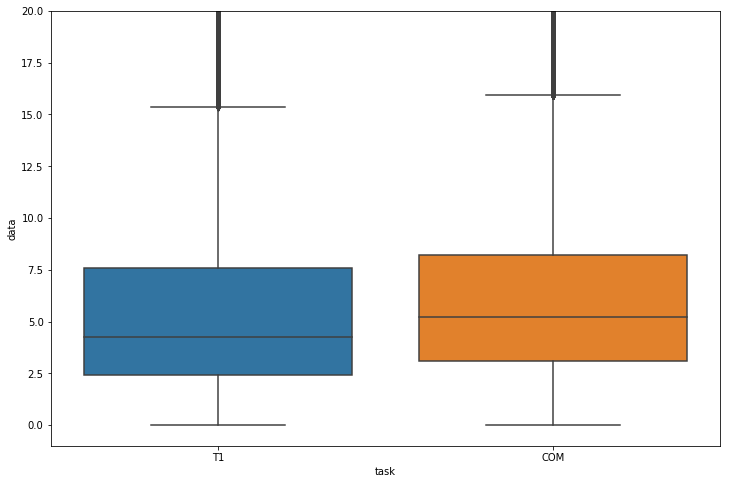

In [31]:
plt.subplots(figsize=(12,8))
whole_list = {'data' : np.append(res_list_t1, res_list_com), 'task': ['T1' for item in res_list_t1] + ['COM' for item in res_list_com]}
data = pd.DataFrame(whole_list)
sns.boxplot(x='task', y='data', data=data)
plt.ylim((-1, 20))

In [32]:
print('----T-Test over Whole Values----')
print('[Mean] T1: %.3f / COM: %.3f' % (np.mean(data[data['task'] == 'T1']['data'].values), np.mean(data[data['task'] == 'COM']['data'].values)))
print('[Std] T1: %.3f / COM: %.3f' % (np.std(data[data['task'] == 'T1']['data'].values), np.std(data[data['task'] == 'COM']['data'].values)))
ttestResult = stats.ttest_ind(data[data['task'] == 'T1']['data'].values, data[data['task'] == 'COM']['data'].values, equal_var=False)
print('[T-Test] T: %.3f / p: %.3f' % ttestResult)

----T-Test over Whole Values----
[Mean] T1: 6.582 / COM: 6.572
[Std] T1: 7.676 / COM: 5.385
[T-Test] T: 0.409 / p: 0.683
